### References/Credits: Animikh Aich - https://github.com/animikhaich

## Algorithm structure:
### The class CNNClassifier has methods like: 
### 1. init_model() which initializes the deep learning model with all the important layers and weights.
### 2. load_data() pre-processes the data and returns the images which are ready as the inputs to the model.
### 3. train() which trains the model with the set number of learning rate, epochs and callbacks.
### 4. predict() which loads the trained model and then predicts with the test input accordingly.

In [33]:
import tensorflow as tf
import numpy as np
import keras
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.backend import set_session
import cv2, os, gc
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob


## DenseNet201 Classifier with Iris Images

2022-12-12 14:06:29.404320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 14:06:29.405153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


2022-12-12 14:06:45.615276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - ETA: 0s - loss: 4.9557 - accuracy: 0.0187

2022-12-12 14:09:12.800102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 188s 1s/step - loss: 4.9557 - accuracy: 0.0187 - val_loss: 4.8657 - val_accuracy: 0.0093 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 86s 754ms/step - loss: 4.0519 - accuracy: 0.1174 - val_loss: 4.4757 - val_accuracy: 0.0723 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 72s 663ms/step - loss: 2.5421 - accuracy: 0.4311 - val_loss: 3.8367 - val_accuracy: 0.1841 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 69s 637ms/step - loss: 0.9612 - accuracy: 0.8002 - val_loss: 3.1232 - val_accuracy: 0.3170 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 70s 650ms/step - loss: 0.2571 - accuracy: 0.9620 - val_loss: 2.8835 - val_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 73s 680ms/step - loss: 0.1033 - accuracy: 0.9901 - val_loss: 2.4172 - val_accuracy: 0.5082 - lr: 1.0000e-04
Epoch 7/20
107/107 [=====================

INFO:tensorflow:Assets written to: ram://2dde1d4d-704d-4749-a201-8d9ca99a2dc6/assets


INFO:tensorflow:Assets written to: ram://2dde1d4d-704d-4749-a201-8d9ca99a2dc6/assets
2022-12-12 14:31:32.449416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 14:31:32.449829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


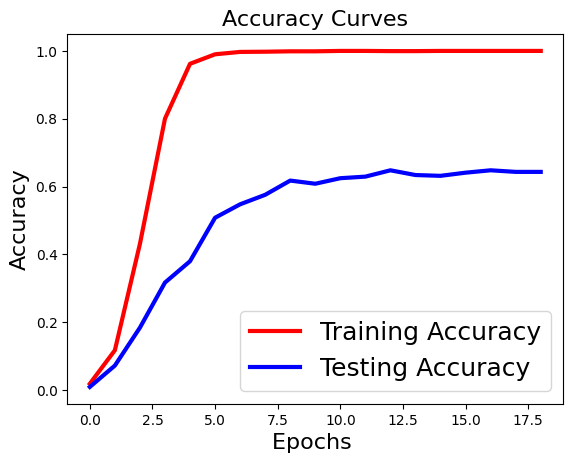

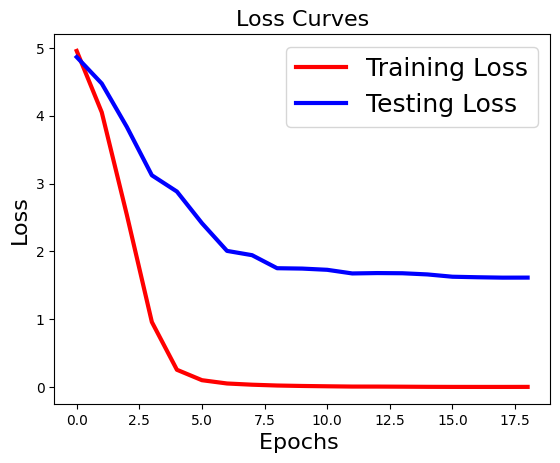

2022-12-12 14:31:56.263147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 35s 2s/step


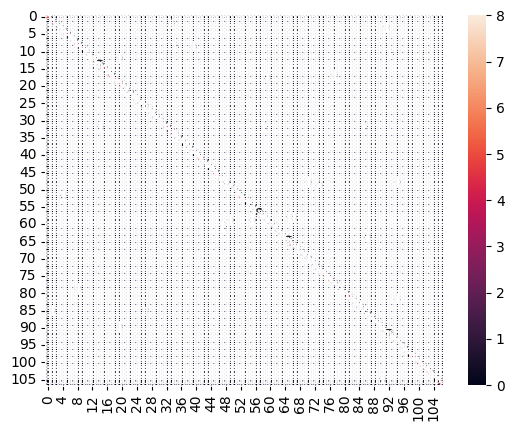

In [48]:
class CNNClassifier:

    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (150, 200, 3)

        else:
            self.resize = True
            self.imshape = shape

        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
       
        self.num_classes = num_classes
        #base = Xception(include_top=False, weights='imagenet', input_shape=self.imshape)
        base = DenseNet201(include_top=False, weights='imagenet', input_shape=self.imshape)
        #base = VGG19(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)
        for layer in self.model.layers:
            layer.trainable = True
       
        return self.model

    def load_data(self, root_path, test_set_percent=0.20, limitedMemory=True):
        imgs=[]
        x=[]
        y=[]
        for filefilepath in glob.iglob(root_path):

            if filefilepath[-1] == 'g':

                img	= cv2.imread(filefilepath)
                imgs_colored=cv2.imread(filefilepath)
                split = filefilepath.split(".")
                label=split[0][12:]
                example_number = split[1]
                imgs.append([imgs_colored,int(label)])

        import random
        random.shuffle(imgs)

        for i,j in imgs:
                self.x.append(i)
                self.y.append(j)

        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent,random_state=42, shuffle=True)

        if limitedMemory:
            del self.x, self.y
            gc.collect()

        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=20, batch_size=64, weights_path='./weights/'):

        if not os.path.exists(weights_path):
            os.makedirs(weights_path)
        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)  #tf.keras.optimizers.Adam(learning_rate)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):

        if X is None and y is None:
            X = self.X_test
            y = self.y_test

        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)

        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss


    def generate_confusion_matrix(self, show_graph=True):
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
       
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):

    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_densenet201.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):

    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    with open('model_history_densenet201.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()
    network.generate_confusion_matrix(show_graph=True)
  
 
if __name__ == '__main__':
    root_path = 'final_iris/*'
    

    train(root_path)
    test(root_path)

## InceptionResNetV2 Classifier with Iris Images

2022-12-11 22:53:29.462363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 22:53:29.462429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30


2022-12-11 22:53:41.886584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - ETA: 0s - loss: 4.8692 - accuracy: 0.0181

2022-12-11 22:55:07.991399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 110s 829ms/step - loss: 4.8692 - accuracy: 0.0181 - val_loss: 4.9216 - val_accuracy: 0.0163 - lr: 1.0000e-04
Epoch 2/30
107/107 [==============================] - 61s 567ms/step - loss: 3.8165 - accuracy: 0.1922 - val_loss: 4.5259 - val_accuracy: 0.0886 - lr: 1.0000e-04
Epoch 3/30
107/107 [==============================] - 64s 599ms/step - loss: 2.1092 - accuracy: 0.5619 - val_loss: 3.8013 - val_accuracy: 0.2028 - lr: 1.0000e-04
Epoch 4/30
107/107 [==============================] - 57s 530ms/step - loss: 0.6414 - accuracy: 0.9083 - val_loss: 3.3403 - val_accuracy: 0.2797 - lr: 1.0000e-04
Epoch 5/30
107/107 [==============================] - 57s 536ms/step - loss: 0.1555 - accuracy: 0.9895 - val_loss: 3.0310 - val_accuracy: 0.3473 - lr: 1.0000e-04
Epoch 6/30
107/107 [==============================] - 57s 535ms/step - loss: 0.0567 - accuracy: 0.9965 - val_loss: 2.7722 - val_accuracy: 0.3730 - lr: 1.0000e-04
Epoch 7/30
107/107 [==================

INFO:tensorflow:Assets written to: ram://ca2919eb-c1d9-404e-8535-39f8f1f764e0/assets


INFO:tensorflow:Assets written to: ram://ca2919eb-c1d9-404e-8535-39f8f1f764e0/assets
2022-12-11 23:09:19.586093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 23:09:19.586140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


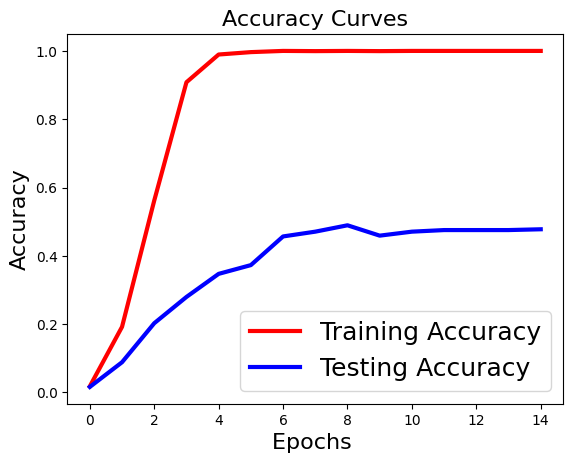

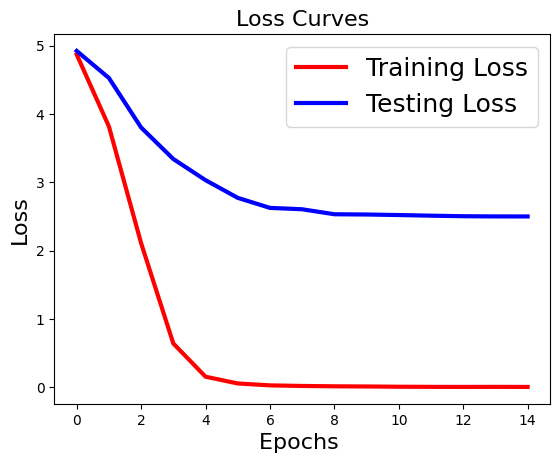

2022-12-11 23:09:44.467748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 25s 2s/step


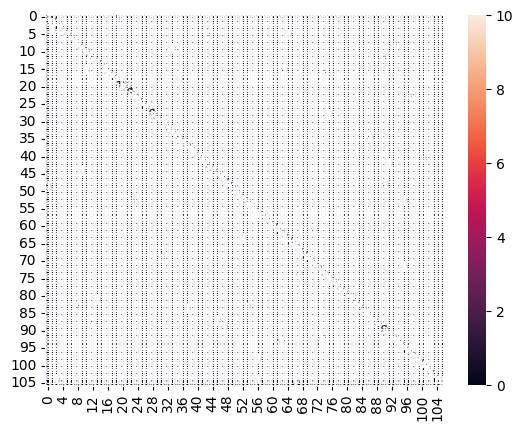

In [31]:
class CNNClassifier:

    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (150, 200, 3)
        else:
            self.resize = True
            self.imshape = shape

        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
       
        self.num_classes = num_classes
        #base = Xception(include_top=False, weights='imagenet', input_shape=self.imshape)
        base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)
        for layer in self.model.layers:
            layer.trainable = True
        return self.model

    def load_data(self, root_path, test_set_percent=0.20, limitedMemory=True):
        imgs=[]
        x=[]
        y=[]
        for filefilepath in glob.iglob(root_path):

            if filefilepath[-1] == 'g':

                img = cv2.imread(filefilepath)
                imgs_colored=cv2.imread(filefilepath)
                split = filefilepath.split(".")
                label=split[0][12:]
                example_number = split[1]
                imgs.append([imgs_colored,int(label)])

        import random
        random.shuffle(imgs)

        for i,j in imgs:
                self.x.append(i)
                self.y.append(j)

        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent,random_state=42, shuffle=True)

        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=30, batch_size=64, weights_path='./weights/'):

        if not os.path.exists(weights_path):
            os.makedirs(weights_path)

        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)  #tf.keras.optimizers.Adam(learning_rate)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):

        if X is None and y is None:
            X = self.X_test
            y = self.y_test

        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)

        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss


    def generate_confusion_matrix(self, show_graph=True):
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
       
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):

    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_inceptionresnetV2.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):

    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    with open('model_history_inceptionresnetV2.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()
    network.generate_confusion_matrix(show_graph=True)

if __name__ == '__main__':
    root_path = 'final_iris/*'
    

    train(root_path)
    test(root_path)

## InceptionV3 Classifier with Iris Images

2022-12-12 02:06:47.131342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 02:06:47.131464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30


2022-12-12 02:06:56.133921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 5.0043 - accuracy: 0.0187

2022-12-12 02:08:36.474733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 124s 1s/step - loss: 5.0043 - accuracy: 0.0187 - val_loss: 4.9261 - val_accuracy: 0.0140 - lr: 1.0000e-04
Epoch 2/30
81/81 [==============================] - 1150s 14s/step - loss: 4.5552 - accuracy: 0.0537 - val_loss: 4.9876 - val_accuracy: 0.0198 - lr: 1.0000e-04
Epoch 3/30
81/81 [==============================] - 133s 2s/step - loss: 3.8719 - accuracy: 0.1581 - val_loss: 4.7075 - val_accuracy: 0.0572 - lr: 1.0000e-04
Epoch 4/30
81/81 [==============================] - 5262s 66s/step - loss: 2.7793 - accuracy: 0.3754 - val_loss: 4.3549 - val_accuracy: 0.0910 - lr: 1.0000e-04
Epoch 5/30
81/81 [==============================] - 2511s 31s/step - loss: 1.7152 - accuracy: 0.6137 - val_loss: 4.1509 - val_accuracy: 0.1377 - lr: 1.0000e-04
Epoch 6/30
81/81 [==============================] - 6519s 81s/step - loss: 0.8728 - accuracy: 0.8224 - val_loss: 3.9798 - val_accuracy: 0.1890 - lr: 1.0000e-04
Epoch 7/30
81/81 [==============================] - 681

INFO:tensorflow:Assets written to: ram://fd0a669d-7f2f-4f7d-9bef-37a5bb192ac6/assets


INFO:tensorflow:Assets written to: ram://fd0a669d-7f2f-4f7d-9bef-37a5bb192ac6/assets
2022-12-12 12:49:54.246282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 12:49:54.246867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


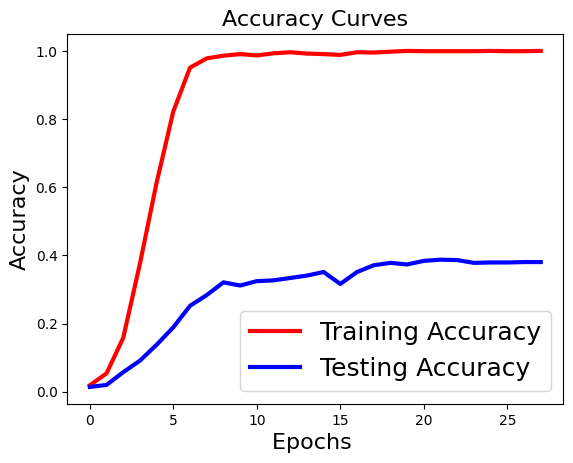

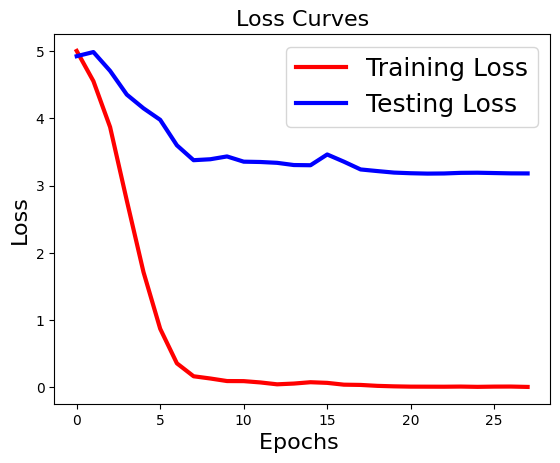

2022-12-12 12:50:18.669409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 24s 715ms/step


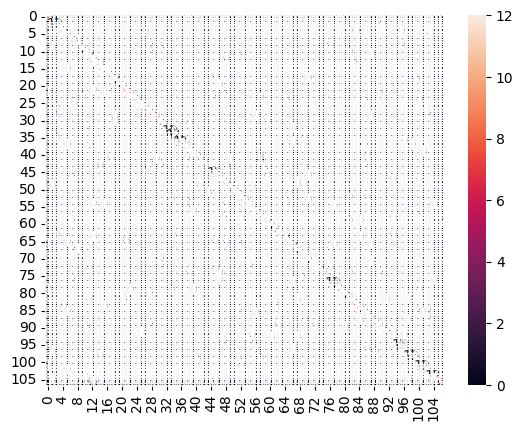

In [46]:
class CNNClassifier:

    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (150, 200, 3)

        else:
            self.resize = True
            self.imshape = shape


        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
       
        self.num_classes = num_classes
        #base = Xception(include_top=False, weights='imagenet', input_shape=self.imshape)
        #base = DenseNet201(include_top=False, weights='imagenet', input_shape=self.imshape)
        #base = ResNet50(include_top=False, weights='imagenet', input_shape=self.imshape)
        base = InceptionV3(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)

        # Make sure all the layers are trainable.
        for layer in self.model.layers:
            layer.trainable = True
       
        return self.model

    def load_data(self, root_path, test_set_percent=0.4, limitedMemory=True):
        imgs=[]
        x=[]
        y=[]
        for filefilepath in glob.iglob(root_path):

            if filefilepath[-1] == 'g':

                img	= cv2.imread(filefilepath)
                imgs_colored=cv2.imread(filefilepath)
                split = filefilepath.split(".")
                label=split[0][12:]
                example_number = split[1]
                imgs.append([imgs_colored,int(label)])

        import random
        random.shuffle(imgs)

        for i,j in imgs:
                self.x.append(i)
                self.y.append(j)
        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent,random_state=42, shuffle=True)

        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=30, batch_size=64, weights_path='./weights/'):
        if not os.path.exists(weights_path):
            os.makedirs(weights_path)

        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)  #tf.keras.optimizers.Adam(learning_rate)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):
        if X is None and y is None:
            X = self.X_test
            y = self.y_test
        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)
        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss


    def generate_confusion_matrix(self, show_graph=True):
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
       
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):

    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_inceptionV3.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):

    network = CNNClassifier()
    network.init_model(num_classes=135)
    network.load_data(root_path)
    with open('model_history_inceptionV3.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()
    network.generate_confusion_matrix(show_graph=True)


if __name__ == '__main__':
    root_path = 'final_iris/*'

    train(root_path)
    test(root_path)